In [1]:
import numpy as np

In [2]:
def extractPoseHand(npy):
    np_matrix=npy.reshape(-1,1629)
    # arr = []
    # print(np_matrix.shape)
    pose  = np_matrix[: ,0:99]
    hands  = np_matrix[: ,1503:1629]
    
 
    arr = np.concatenate((pose, hands), axis=1)


      
    return arr

In [3]:
import random
import os
import numpy as np

crossValidationDataPaths=['NORMALIZED/NumericalData/ML/Training/RightHand','NORMALIZED/NumericalData/ML/Training/LeftHand']
testPaths=['NORMALIZED/NumericalData/ML/Test/RightHand','NORMALIZED/NumericalData/ML/Test/LeftHand']



ml_instances_paths=[]
for path in crossValidationDataPaths:
    #print(path)
    classFolders= os.listdir(path)
    for classFolder in classFolders:
        classFolder_path=f'{path}/{classFolder}'
        classTrials =os.listdir(classFolder_path)
        for trial in classTrials:
            trialPath =f'{classFolder_path}/{trial}'
            #print(trialPath)
            ml_instances_paths.append(trialPath)
            


#randomize the list
random.shuffle(ml_instances_paths)



x_shape =[]
y_shape =[]
for ml_instances_path in ml_instances_paths:
    label = ml_instances_path.split('/')
    label = label[len(label)-1].split('_')[0]
    #print(label)
    y_shape.append(int(label))
    npy =np.load(ml_instances_path)
    npy = npy*100
  
    # npy_matrix=npy.reshape(-1,1629)
   
    npy_matrix=extractPoseHand(npy)
    x_shape.append(npy_matrix)    

test_instances_paths=[]
for path in testPaths:
    #print(path)
    testFolders= os.listdir(path)
    for testFolder in testFolders:
        testFolder_path=f'{path}/{testFolder}'
        testTrials =os.listdir(testFolder_path)
        for trial in testTrials:
            trialPath =f'{testFolder_path}/{trial}'
            #print(trialPath)
            test_instances_paths.append(trialPath)


test_x_shape =[]
test_y_shape =[]
for test_instances_path in test_instances_paths:
    label = test_instances_path.split('/')
    label = label[len(label)-1].split('_')[0]
    #print(label)
    test_y_shape.append(int(label))
    npy =np.load(test_instances_path)
    npy=npy*100
    # npy_matrix=npy.reshape(-1,1629)

    npy_matrix=extractPoseHand(npy)
    
    test_x_shape.append(npy_matrix)    


In [4]:
# training the total data
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Bidirectional, LSTM, Flatten, Dense,Input,  Dropout, BatchNormalization, GRU, Attention,Concatenate, Conv1D, Masking, Embedding
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.optimizers import Adam
import os

epochs = 200
batch_size = 64
NO_CLASSES = 60 #Changes according to no of class
MAX_FRMAE = 164

learning_rate = 0.00003
input_shape = (MAX_FRMAE,225) # pose hands



log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

print(y_shape)
#y_onehot = to_categorical(y_shape).astype(int)
label_encoder=LabelEncoder()
y_encoded =label_encoder.fit_transform(y_shape)
y_onehot =to_categorical(y_encoded,num_classes=NO_CLASSES)
print(len(y_onehot))



all_accuracies = []
x_shapeML = np.array(x_shape) #.astype(int)
x_train=x_shapeML
y_train =y_onehot

test_x_shapeML = np.array(test_x_shape) #.astype(int)
x_val=test_x_shapeML

#y_val = to_categorical(test_y_shape).astype(int)
y_encoded =label_encoder.fit_transform(test_y_shape)
y_val =to_categorical(y_encoded,num_classes=NO_CLASSES)


print('Train shape: ',x_train.shape, y_train.shape,'Test Shape: ', x_val.shape, y_val.shape)

2023-12-31 18:41:29.817030: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-31 18:41:29.900657: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-31 18:41:29.900691: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-31 18:41:29.902038: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-31 18:41:29.913462: I tensorflow/core/platform/cpu_feature_guar

[51, 0, 27, 55, 14, 4, 34, 55, 55, 53, 50, 58, 6, 31, 10, 18, 46, 56, 20, 56, 28, 53, 4, 52, 17, 10, 39, 51, 22, 44, 57, 49, 5, 40, 7, 35, 36, 14, 59, 4, 13, 7, 38, 14, 31, 28, 46, 58, 27, 32, 28, 14, 31, 34, 40, 11, 21, 57, 57, 58, 52, 57, 37, 33, 21, 58, 24, 48, 19, 10, 53, 0, 3, 5, 59, 32, 26, 56, 38, 57, 57, 41, 59, 12, 42, 19, 18, 36, 51, 18, 4, 33, 31, 4, 9, 59, 0, 30, 24, 30, 55, 43, 33, 10, 41, 15, 28, 49, 29, 49, 9, 4, 10, 2, 59, 27, 10, 36, 40, 22, 9, 21, 34, 56, 26, 25, 31, 56, 49, 3, 50, 24, 44, 53, 33, 43, 47, 53, 7, 33, 18, 52, 25, 48, 25, 48, 41, 8, 49, 59, 35, 38, 54, 53, 8, 17, 42, 50, 16, 57, 30, 57, 55, 20, 8, 46, 15, 57, 58, 27, 56, 58, 44, 34, 32, 19, 48, 25, 21, 59, 13, 37, 30, 13, 19, 7, 5, 54, 3, 7, 13, 3, 57, 8, 8, 54, 3, 53, 1, 12, 22, 40, 21, 39, 15, 52, 12, 54, 53, 47, 49, 18, 23, 54, 8, 59, 25, 48, 59, 50, 36, 27, 5, 25, 45, 29, 18, 3, 26, 24, 18, 45, 54, 51, 11, 20, 58, 1, 59, 50, 23, 54, 29, 45, 36, 12, 23, 45, 0, 46, 54, 30, 5, 17, 57, 8, 56, 8, 10, 53, 

In [5]:


# Define and compile the model


num_folds = 10
# Train the model
kfold = KFold(n_splits=num_folds, shuffle=True)


i = 1

all_accuracies = []
test_accuracies = []
conf_matrixes = []
bestTestAccuracy=0
bestTest=0

for train, test in kfold.split(x_train, y_train):

    input = Input(shape=input_shape)
    bd1 = Bidirectional(LSTM(units=64, return_sequences=True))(input)
    # bn1 = BatchNormalization()(bd1)
    bd11 = Dropout(0.3)(bd1)

    bd2 = Bidirectional(LSTM(units=64, return_sequences=True))(input)
    # bd22 = BatchNormalization()(bd2)

    att = Attention(use_scale=True)([bd2, bd11])

    merged = Concatenate(axis=-1)([bd2, att])

    flat = Flatten()(merged)
    dense = Dense(units=64, activation='silu')(flat)
    dp2 = Dropout(0.3)(dense)
    out = Dense(NO_CLASSES, activation='softmax')(dp2)
    
    model = Model(input, out)
    optimizer = Adam(learning_rate=learning_rate)
    early_stoppage = EarlyStopping(monitor="loss",mode="auto", patience = 5,  restore_best_weights=True)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    
    print("---------------fold {} -----------".format(i))
    
    model.fit(x_train[train], y_train[train], epochs=epochs,  batch_size=batch_size, callbacks=[early_stoppage],validation_data=(x_train[test],y_train[test]))

    # Evaluate the model on the validation set
    y_val_pred = model.predict(x_train[test])
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true_classes = np.argmax(y_train[test], axis=1)

        # Calculate accuracy for the fold
    test_accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
    # all_accuracies.append(test_accuracy)
    all_accuracies.append(test_accuracy)
    # average_accuracy = np.mean(all_accuracies)


    ##avg_acc = all_accuracies/epochs

    print(f'Validation Accuracy Fold {i}: {test_accuracy}')



    # Evaluate the model on the test set
    y_val_pred = model.predict(x_val)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true_classes = np.argmax(y_val, axis=1)
    test_accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
    if test_accuracy >bestTestAccuracy:
        bestTestAccuracy=test_accuracy
        bestTest=i
    print(f'Test - Accuracy: {test_accuracy}')

    test_accuracies.append(test_accuracy)

    conf_mat = confusion_matrix(y_val_true_classes,y_val_pred_classes)

    conf_matrixes.append(conf_mat)
    i += 1
    
    


average_accuracy = np.mean(all_accuracies)
print("Average  cross validation accuracy: {average_accuracy}")



average_accuracy = np.mean(test_accuracies)
print("Average test accuracy: {average_accuracy}")


2023-12-31 18:41:41.546629: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-12-31 18:41:41.547247: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: DeepLearning2
2023-12-31 18:41:41.547255: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: DeepLearning2
2023-12-31 18:41:41.547368: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 525.147.5
2023-12-31 18:41:41.547388: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 470.223.2
2023-12-31 18:41:41.547393: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:244] kernel version 470.223.2 does not match DSO version 525.147.5 -- cannot find working devices in this configuration


---------------fold 1 -----------
Epoch 1/200


W0000 00:00:1704026519.227409  480638 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.8639 - accuracy: 0.0756

W0000 00:00:1704026536.495833  480638 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 23s 149ms/step - loss: 3.8639 - accuracy: 0.0756 - val_loss: 3.4839 - val_accuracy: 0.1729
Epoch 2/200
113/113 [==============================] - 16s 137ms/step - loss: 3.3066 - accuracy: 0.1896 - val_loss: 2.9748 - val_accuracy: 0.3246
Epoch 3/200
113/113 [==============================] - 16s 144ms/step - loss: 2.9392 - accuracy: 0.2658 - val_loss: 2.6097 - val_accuracy: 0.3694
Epoch 4/200
113/113 [==============================] - 15s 133ms/step - loss: 2.6572 - accuracy: 0.3224 - val_loss: 2.3285 - val_accuracy: 0.4590
Epoch 5/200
113/113 [==============================] - 14s 127ms/step - loss: 2.4393 - accuracy: 0.3735 - val_loss: 2.1067 - val_accuracy: 0.5249
Epoch 6/200
113/113 [==============================] - 15s 133ms/step - loss: 2.2271 - accuracy: 0.4233 - val_loss: 1.8908 - val_accuracy: 0.5846
Epoch 7/200
113/113 [==============================] - 16s 138ms/step - loss: 2.0614 - accuracy: 0.4642 - val_loss: 1.7031 - val_accurac

W0000 00:00:1704028055.786391  480638 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 2s 36ms/step
Validation Accuracy Fold 1: 0.9614427860696517
40/40 [==============================] - 2s 40ms/step
Test - Accuracy: 0.6434169278996865
---------------fold 2 -----------
Epoch 1/200


W0000 00:00:1704028077.532869  480638 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.9331 - accuracy: 0.0623

W0000 00:00:1704028094.364706  480638 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 22s 149ms/step - loss: 3.9331 - accuracy: 0.0623 - val_loss: 3.6646 - val_accuracy: 0.1544
Epoch 2/200
113/113 [==============================] - 16s 138ms/step - loss: 3.4494 - accuracy: 0.1551 - val_loss: 3.1335 - val_accuracy: 0.2665
Epoch 3/200
113/113 [==============================] - 15s 132ms/step - loss: 3.0280 - accuracy: 0.2445 - val_loss: 2.7170 - val_accuracy: 0.3512
Epoch 4/200
113/113 [==============================] - 15s 130ms/step - loss: 2.7394 - accuracy: 0.3080 - val_loss: 2.4148 - val_accuracy: 0.4471
Epoch 5/200
113/113 [==============================] - 14s 127ms/step - loss: 2.4961 - accuracy: 0.3632 - val_loss: 2.1730 - val_accuracy: 0.5081
Epoch 6/200
113/113 [==============================] - 15s 130ms/step - loss: 2.2758 - accuracy: 0.4126 - val_loss: 1.9646 - val_accuracy: 0.5778
Epoch 7/200
113/113 [==============================] - 15s 134ms/step - loss: 2.1365 - accuracy: 0.4419 - val_loss: 1.8045 - val_accurac

W0000 00:00:1704030296.138408  480638 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 2s 36ms/step
Validation Accuracy Fold 2: 0.9713574097135741
40/40 [==============================] - 1s 37ms/step
Test - Accuracy: 0.6253918495297806
---------------fold 3 -----------
Epoch 1/200


W0000 00:00:1704030316.595487  480638 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.8967 - accuracy: 0.0710

W0000 00:00:1704030334.842302  480638 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 24s 161ms/step - loss: 3.8967 - accuracy: 0.0710 - val_loss: 3.4969 - val_accuracy: 0.2017
Epoch 2/200
113/113 [==============================] - 15s 134ms/step - loss: 3.3057 - accuracy: 0.1915 - val_loss: 2.9052 - val_accuracy: 0.2889
Epoch 3/200
113/113 [==============================] - 15s 136ms/step - loss: 2.8843 - accuracy: 0.2652 - val_loss: 2.5296 - val_accuracy: 0.4110
Epoch 4/200
113/113 [==============================] - 16s 140ms/step - loss: 2.5921 - accuracy: 0.3305 - val_loss: 2.2261 - val_accuracy: 0.4944
Epoch 5/200
113/113 [==============================] - 15s 134ms/step - loss: 2.3551 - accuracy: 0.3903 - val_loss: 1.9635 - val_accuracy: 0.5629
Epoch 6/200
113/113 [==============================] - 16s 138ms/step - loss: 2.1478 - accuracy: 0.4411 - val_loss: 1.7693 - val_accuracy: 0.6351
Epoch 7/200
113/113 [==============================] - 15s 136ms/step - loss: 2.0108 - accuracy: 0.4682 - val_loss: 1.6778 - val_accurac

W0000 00:00:1704031988.358751  480638 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 2s 43ms/step
Validation Accuracy Fold 3: 0.9813200498132005
40/40 [==============================] - 1s 34ms/step
Test - Accuracy: 0.5815047021943573
---------------fold 4 -----------
Epoch 1/200


W0000 00:00:1704032005.817827  480638 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.9115 - accuracy: 0.0645

W0000 00:00:1704032022.658972  480638 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 22s 151ms/step - loss: 3.9115 - accuracy: 0.0645 - val_loss: 3.5994 - val_accuracy: 0.1382
Epoch 2/200
113/113 [==============================] - 16s 140ms/step - loss: 3.3696 - accuracy: 0.1754 - val_loss: 2.9873 - val_accuracy: 0.3337
Epoch 3/200
113/113 [==============================] - 14s 122ms/step - loss: 2.9684 - accuracy: 0.2645 - val_loss: 2.5745 - val_accuracy: 0.4072
Epoch 4/200
113/113 [==============================] - 15s 133ms/step - loss: 2.6883 - accuracy: 0.3278 - val_loss: 2.3227 - val_accuracy: 0.4720
Epoch 5/200
113/113 [==============================] - 15s 133ms/step - loss: 2.4509 - accuracy: 0.3803 - val_loss: 2.0665 - val_accuracy: 0.5666
Epoch 6/200
113/113 [==============================] - 15s 135ms/step - loss: 2.2772 - accuracy: 0.4210 - val_loss: 1.8781 - val_accuracy: 0.6065
Epoch 7/200
113/113 [==============================] - 15s 135ms/step - loss: 2.1186 - accuracy: 0.4595 - val_loss: 1.6952 - val_accurac

W0000 00:00:1704034066.706112  480638 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 2s 35ms/step
Validation Accuracy Fold 4: 0.975093399750934
40/40 [==============================] - 2s 47ms/step
Test - Accuracy: 0.6003134796238244
---------------fold 5 -----------
Epoch 1/200


W0000 00:00:1704034086.379098  480638 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.8376 - accuracy: 0.0758

W0000 00:00:1704034103.608830  480638 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 23s 154ms/step - loss: 3.8376 - accuracy: 0.0758 - val_loss: 3.4331 - val_accuracy: 0.1731
Epoch 2/200
113/113 [==============================] - 15s 136ms/step - loss: 3.2473 - accuracy: 0.1980 - val_loss: 2.8591 - val_accuracy: 0.3288
Epoch 3/200
113/113 [==============================] - 15s 133ms/step - loss: 2.8507 - accuracy: 0.2846 - val_loss: 2.5078 - val_accuracy: 0.4172
Epoch 4/200
113/113 [==============================] - 16s 143ms/step - loss: 2.5631 - accuracy: 0.3462 - val_loss: 2.2165 - val_accuracy: 0.5342
Epoch 5/200
113/113 [==============================] - 16s 144ms/step - loss: 2.3527 - accuracy: 0.3812 - val_loss: 1.9922 - val_accuracy: 0.5828
Epoch 6/200
113/113 [==============================] - 15s 135ms/step - loss: 2.1824 - accuracy: 0.4227 - val_loss: 1.8329 - val_accuracy: 0.5965
Epoch 7/200
113/113 [==============================] - 16s 140ms/step - loss: 2.0262 - accuracy: 0.4676 - val_loss: 1.6914 - val_accurac

W0000 00:00:1704035669.731101  480638 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 2s 37ms/step
Validation Accuracy Fold 5: 0.9564134495641345
40/40 [==============================] - 2s 38ms/step
Test - Accuracy: 0.5963949843260188
---------------fold 6 -----------
Epoch 1/200


W0000 00:00:1704035691.335061  480638 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.8750 - accuracy: 0.0683

W0000 00:00:1704035708.018647  480638 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 22s 150ms/step - loss: 3.8750 - accuracy: 0.0683 - val_loss: 3.4398 - val_accuracy: 0.1818
Epoch 2/200
113/113 [==============================] - 17s 148ms/step - loss: 3.2307 - accuracy: 0.1901 - val_loss: 2.8284 - val_accuracy: 0.3313
Epoch 3/200
113/113 [==============================] - 16s 139ms/step - loss: 2.7908 - accuracy: 0.2832 - val_loss: 2.4367 - val_accuracy: 0.4371
Epoch 4/200
113/113 [==============================] - 15s 134ms/step - loss: 2.5141 - accuracy: 0.3499 - val_loss: 2.2056 - val_accuracy: 0.4956
Epoch 5/200
113/113 [==============================] - 15s 132ms/step - loss: 2.2917 - accuracy: 0.4070 - val_loss: 1.9565 - val_accuracy: 0.5305
Epoch 6/200
113/113 [==============================] - 15s 135ms/step - loss: 2.0941 - accuracy: 0.4465 - val_loss: 1.7974 - val_accuracy: 0.6077
Epoch 7/200
113/113 [==============================] - 15s 131ms/step - loss: 1.9468 - accuracy: 0.4846 - val_loss: 1.6012 - val_accurac

W0000 00:00:1704037181.465460  480638 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 2s 35ms/step
Validation Accuracy Fold 6: 0.9651307596513076
40/40 [==============================] - 2s 42ms/step
Test - Accuracy: 0.6261755485893417
---------------fold 7 -----------
Epoch 1/200


W0000 00:00:1704037202.525453  480638 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.8630 - accuracy: 0.0695

W0000 00:00:1704037220.406503  480638 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 24s 159ms/step - loss: 3.8630 - accuracy: 0.0695 - val_loss: 3.4323 - val_accuracy: 0.1644
Epoch 2/200
113/113 [==============================] - 16s 143ms/step - loss: 3.2415 - accuracy: 0.1988 - val_loss: 2.8387 - val_accuracy: 0.3375
Epoch 3/200
113/113 [==============================] - 16s 139ms/step - loss: 2.8389 - accuracy: 0.2844 - val_loss: 2.4765 - val_accuracy: 0.4222
Epoch 4/200
113/113 [==============================] - 15s 131ms/step - loss: 2.5402 - accuracy: 0.3531 - val_loss: 2.1697 - val_accuracy: 0.5068
Epoch 5/200
113/113 [==============================] - 15s 135ms/step - loss: 2.3154 - accuracy: 0.4041 - val_loss: 1.9301 - val_accuracy: 0.5940
Epoch 6/200
113/113 [==============================] - 15s 132ms/step - loss: 2.1209 - accuracy: 0.4487 - val_loss: 1.7532 - val_accuracy: 0.6301
Epoch 7/200
113/113 [==============================] - 14s 126ms/step - loss: 1.9834 - accuracy: 0.4813 - val_loss: 1.5991 - val_accurac

W0000 00:00:1704039061.912828  480638 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 2s 37ms/step
Validation Accuracy Fold 7: 0.962640099626401
40/40 [==============================] - 1s 35ms/step
Test - Accuracy: 0.5760188087774295
---------------fold 8 -----------
Epoch 1/200


W0000 00:00:1704039082.421352  480638 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.8972 - accuracy: 0.0728

W0000 00:00:1704039099.611698  480638 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 23s 152ms/step - loss: 3.8972 - accuracy: 0.0728 - val_loss: 3.4848 - val_accuracy: 0.1955
Epoch 2/200
113/113 [==============================] - 16s 139ms/step - loss: 3.3090 - accuracy: 0.1901 - val_loss: 2.8709 - val_accuracy: 0.2765
Epoch 3/200
113/113 [==============================] - 14s 127ms/step - loss: 2.8713 - accuracy: 0.2755 - val_loss: 2.4545 - val_accuracy: 0.4309
Epoch 4/200
113/113 [==============================] - 16s 141ms/step - loss: 2.5719 - accuracy: 0.3435 - val_loss: 2.1905 - val_accuracy: 0.5181
Epoch 5/200
113/113 [==============================] - 16s 139ms/step - loss: 2.3342 - accuracy: 0.3987 - val_loss: 1.9357 - val_accuracy: 0.5778
Epoch 6/200
113/113 [==============================] - 15s 137ms/step - loss: 2.1451 - accuracy: 0.4460 - val_loss: 1.7333 - val_accuracy: 0.6501
Epoch 7/200
113/113 [==============================] - 7s 64ms/step - loss: 1.9636 - accuracy: 0.4985 - val_loss: 1.5680 - val_accuracy:

W0000 00:00:1704040621.442122  480638 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 2s 41ms/step
Validation Accuracy Fold 8: 0.975093399750934
40/40 [==============================] - 2s 39ms/step
Test - Accuracy: 0.572884012539185
---------------fold 9 -----------
Epoch 1/200


W0000 00:00:1704040637.986834  480638 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.9002 - accuracy: 0.0708

W0000 00:00:1704040656.956713  480638 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 24s 168ms/step - loss: 3.9002 - accuracy: 0.0708 - val_loss: 3.5774 - val_accuracy: 0.1619
Epoch 2/200
113/113 [==============================] - 16s 142ms/step - loss: 3.3499 - accuracy: 0.1873 - val_loss: 3.0407 - val_accuracy: 0.2939
Epoch 3/200
113/113 [==============================] - 16s 145ms/step - loss: 2.9906 - accuracy: 0.2658 - val_loss: 2.7073 - val_accuracy: 0.3773
Epoch 4/200
113/113 [==============================] - 16s 144ms/step - loss: 2.7121 - accuracy: 0.3244 - val_loss: 2.4004 - val_accuracy: 0.4707
Epoch 5/200
113/113 [==============================] - 17s 148ms/step - loss: 2.4883 - accuracy: 0.3789 - val_loss: 2.2336 - val_accuracy: 0.5268
Epoch 6/200
113/113 [==============================] - 17s 148ms/step - loss: 2.3012 - accuracy: 0.4257 - val_loss: 2.0276 - val_accuracy: 0.5442
Epoch 7/200
113/113 [==============================] - 17s 148ms/step - loss: 2.1679 - accuracy: 0.4481 - val_loss: 1.8595 - val_accurac

W0000 00:00:1704042521.601620  480638 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 2s 42ms/step
Validation Accuracy Fold 9: 0.9663760896637609
40/40 [==============================] - 2s 39ms/step
Test - Accuracy: 0.603448275862069
---------------fold 10 -----------
Epoch 1/200


W0000 00:00:1704042541.146367  480638 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.9490 - accuracy: 0.0624

W0000 00:00:1704042557.130208  480638 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 21s 141ms/step - loss: 3.9490 - accuracy: 0.0624 - val_loss: 3.6195 - val_accuracy: 0.1432
Epoch 2/200
113/113 [==============================] - 15s 132ms/step - loss: 3.3974 - accuracy: 0.1739 - val_loss: 3.0488 - val_accuracy: 0.2790
Epoch 3/200
113/113 [==============================] - 15s 130ms/step - loss: 2.9401 - accuracy: 0.2728 - val_loss: 2.6250 - val_accuracy: 0.3798
Epoch 4/200
113/113 [==============================] - 16s 137ms/step - loss: 2.6241 - accuracy: 0.3397 - val_loss: 2.3639 - val_accuracy: 0.4545
Epoch 5/200
113/113 [==============================] - 15s 131ms/step - loss: 2.3895 - accuracy: 0.3957 - val_loss: 2.1155 - val_accuracy: 0.5031
Epoch 6/200
113/113 [==============================] - 15s 135ms/step - loss: 2.1801 - accuracy: 0.4436 - val_loss: 1.9174 - val_accuracy: 0.5492
Epoch 7/200
113/113 [==============================] - 16s 143ms/step - loss: 2.0231 - accuracy: 0.4790 - val_loss: 1.7225 - val_accurac

W0000 00:00:1704044136.840781  480638 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 2097152 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 2s 39ms/step
Validation Accuracy Fold 10: 0.9701120797011208
40/40 [==============================] - 1s 32ms/step
Test - Accuracy: 0.5658307210031348
Average  cross validation accuracy: {average_accuracy}
Average test accuracy: {average_accuracy}


In [6]:
print(test_accuracies)
print(np.average(test_accuracies))
print(all_accuracies)
print(np.average(all_accuracies))

[0.6434169278996865, 0.6253918495297806, 0.5815047021943573, 0.6003134796238244, 0.5963949843260188, 0.6261755485893417, 0.5760188087774295, 0.572884012539185, 0.603448275862069, 0.5658307210031348]
0.5991379310344828
[0.9614427860696517, 0.9713574097135741, 0.9813200498132005, 0.975093399750934, 0.9564134495641345, 0.9651307596513076, 0.962640099626401, 0.975093399750934, 0.9663760896637609, 0.9701120797011208]
0.968497952330502


test accuracies:  [0.6434169278996865, 0.6253918495297806, 0.5815047021943573, 0.6003134796238244, 0.5963949843260188, 0.6261755485893417, 0.5760188087774295, 0.572884012539185, 0.603448275862069, 0.5658307210031348] 0
validation accuracies:  [0.9614427860696517, 0.9713574097135741, 0.9813200498132005, 0.975093399750934, 0.9564134495641345, 0.9651307596513076, 0.962640099626401, 0.975093399750934, 0.9663760896637609, 0.9701120797011208]
60


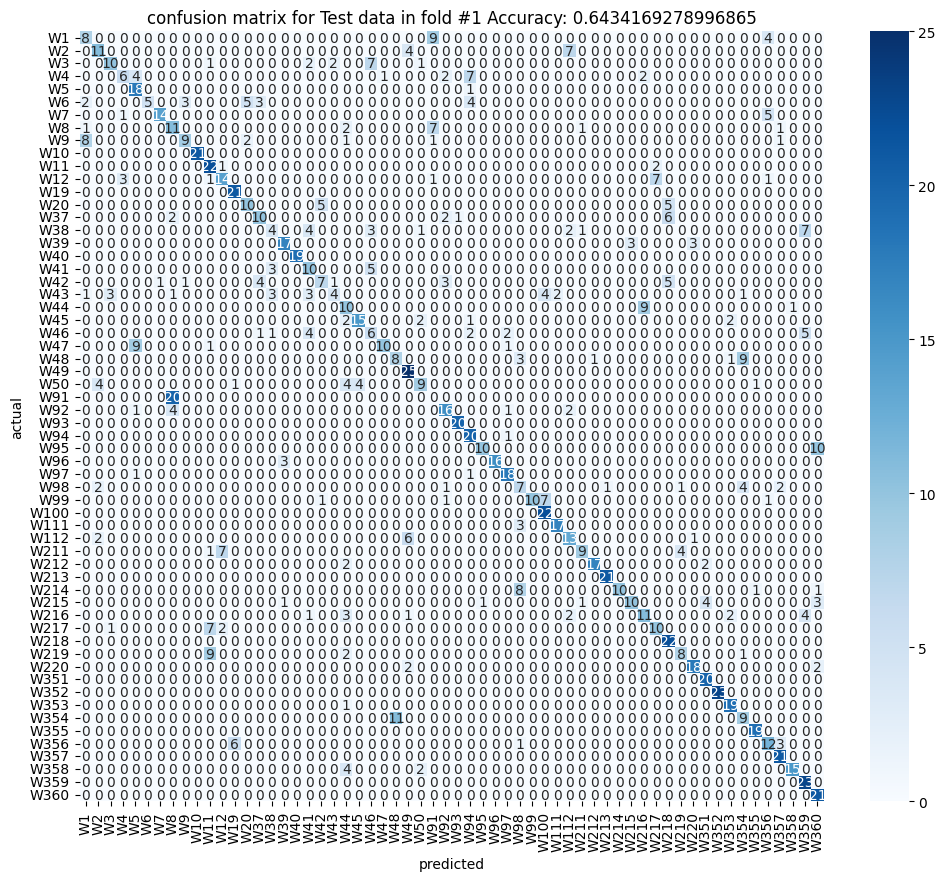

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat= conf_matrixes[bestTest-1]
print('test accuracies: ',test_accuracies, bestTest-1)
print ('validation accuracies: ',all_accuracies)
# average_conf_mat = np.mean(conf_matrixes, axis=0)
# for conf_matrix in conf_matrixes:
#     average_conf_mat +=  conf_matrix
# y_val_true_classes,y_val_pred_classes
ylabel =['W1','W2','W3','W4','W5','W6','W7','W8','W9','W10','W11','W12','W19','W20','W37','W38','W39','W40','W41','W42','W43','W44','W45','W46','W47','W48','W49','W50','W91','W92','W93','W94','W95','W96','W97','W98','W99','W100','W111','W112','W211','W212','W213','W214','W215','W216','W217','W218','W219','W220','W351','W352','W353','W354','W355','W356','W357','W358','W359','W360']
print(len(ylabel))
# ticklabels=np.unique(y_val_true_classes)
plt.figure(figsize=(12,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap='Blues',xticklabels=ylabel,yticklabels=ylabel)
plt.title(f'confusion matrix for Test data in fold #{bestTest} Accuracy: {test_accuracies[bestTest-1]}')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()
